# Notebook for Training with Faster RCNN

We'll import code from the scripts folder so we don't have to clutter this notebook

In [5]:
%matplotlib inline

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import sys
import torch
import torchvision

from albumentations import OneOf

sys.path.append(os.path.join('..', 'scripts'))
from models import WheatModel

sns.set()

%load_ext autoreload
%autoreload

ALLOW_AUTOMATIC_SHUTDOWN = True # allow the script to automatically shutdown your computer after use.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\Alan\Anaconda3\envs\wheat-detection\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


Iteration #50 loss: 1.3447210788726807
Iteration #100 loss: 1.013862133026123
Iteration #150 loss: 0.7962999939918518
Iteration #200 loss: 0.6117619872093201
Iteration #250 loss: 1.3959277868270874
Iteration #300 loss: 0.6903669834136963
Iteration #350 loss: 0.9220247268676758
Iteration #400 loss: 0.9087163805961609
Iteration #450 loss: 0.7211529016494751
Iteration #500 loss: 0.9068183898925781
Iteration #550 loss: 0.7594872117042542
Iteration #600 loss: 0.8021853566169739
Iteration #650 loss: 1.0818212032318115
Epoch #0 loss: 0.8977792149561423
Wall time: 8min 9s


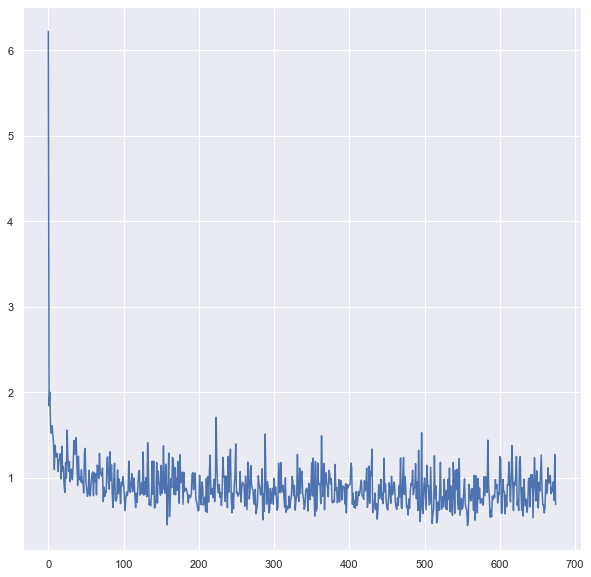

In [7]:
%%time
base_path = os.path.join('..', 'data')

model = WheatModel(
    base_path=base_path,
    num_epochs=1,
    train_val_split=0.8,
    transforms=[A.Flip(0.5), 
#                     A.RandomBrightnessContrast(), 
                OneOf([
                    A.RandomBrightnessContrast(), 
                    A.HueSaturationValue()
                ], p=0.5),
                OneOf([
                    A.MotionBlur()
                ])
               ]
)
loss=model.main()
plt.figure(figsize=(10, 10))
plt.plot(loss)
model.save_params()

In [8]:
# Our testing sample
sample_id = '1ef16dab1'

gt_boxes = model.train_df[model.train_df['image_id'] == sample_id][['x', 'y', 'w', 'h']].values
gt_boxes = gt_boxes.astype(np.int)

# Ground-truth boxes of our sample
gt_boxes

array([[954, 391,  70,  90],
       [660, 220,  95, 102],
       [ 64, 209,  76,  57],
       [896,  99, 102,  69],
       [747, 460,  72,  77],
       [885, 163, 103,  69],
       [514, 399,  90,  97],
       [702, 794,  97,  99],
       [721, 624,  98, 108],
       [826, 512,  82,  94],
       [883, 944,  79,  74],
       [247, 594, 123,  92],
       [673, 514,  95, 113],
       [829, 847, 102, 110],
       [ 94, 737,  92, 107],
       [588, 568,  75, 107],
       [158, 890, 103,  64],
       [744, 906,  75,  79],
       [826,  33,  72,  74],
       [601,  69,  67,  87]])

In [12]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [13]:
model.model.eval()
detection_threshold = 0.5
results = []

for images, targets, image_ids in model.valid_data_loader:

    images = list(image.to(model.device) for image in images)
    outputs = model.model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }

        
        results.append(result)

In [21]:
results

[{'image_id': 'f931c0224',
  'PredictionString': '0.9802 340 504 94 115 0.9754 262 339 94 83 0.9747 798 369 131 78 0.9699 574 492 133 87 0.9594 179 868 128 77 0.9562 782 893 114 93 0.9549 906 478 109 74 0.9516 966 542 58 117 0.9498 126 485 150 107 0.9496 534 879 81 79 0.9421 807 663 70 80 0.9397 557 319 69 76 0.9390 155 789 173 82 0.9365 430 408 106 86 0.9326 0 602 82 86 0.9257 331 241 167 91 0.9165 606 906 89 100 0.9158 6 380 74 78 0.9152 883 583 73 76 0.9083 913 872 78 91 0.8966 0 528 57 78 0.8908 56 268 87 72 0.8903 405 67 99 64 0.8899 564 737 76 93 0.8823 917 103 80 81 0.8776 788 567 72 74 0.8562 298 455 73 71 0.8468 575 668 95 82 0.8227 271 114 77 81 0.8174 758 467 122 60 0.7968 918 753 90 63 0.7895 279 209 111 73 0.7780 724 538 87 73 0.7667 451 645 56 80 0.7392 0 780 62 103 0.6919 978 139 46 70 0.6516 148 593 74 83 0.6228 96 359 69 76 0.5304 801 27 94 107'},
 {'image_id': 'd3e9389e1',
  'PredictionString': '0.9784 791 162 72 107 0.9750 935 351 83 103 0.9727 257 608 81 99 0.9688 7

In [3]:
# ###################################################################################################################
# #################### WARNING THIS WILL SHUT DOWN THE COMPUTER IF IT IS UNCOMMENTED ################################
# ###################################################################################################################
# if ALLOW_AUTOMATIC_SHUTDOWN:
#     os.system('shutdown -s -t 0')
# ###################################################################################################################
# #################### WARNING THIS WILL SHUT DOWN THE COMPUTER IF IT IS UNCOMMENTED ################################
# ###################################################################################################################